# Analysis of Gene Expression Variability by Class
This notebook analyzes the variability of genes within classes.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import util_classifier
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest
from common_python.plots import util_plots as common_plots

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

trinary_short = TrinaryData()
trinary_short.df_X.columns = trinary_short.features
trinary_long = TrinaryData(is_averaged=False, is_dropT1=False)
trinary_long.df_X.columns = trinary_long.features

%matplotlib inline

In [2]:
trinary_long.df_X.head()

,Rv1131,Rv1927,Rv3085,Rv3083,Rv2642,Rv3741c,Rv0841,Rv1129c,Rv3086,Rv0260c,...,Rv3267,Rv0288,Rv0129c,Rv3135,Rv0351,Rv2147c,Rv2737c,Rv0440,Rv3269,Rv3418c
T1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
trinary_long.ser_y.head()

T1.0    0
T1.1    0
T1.2    0
T2.0    1
T2.1    1
Name: name, dtype: int64

## F-Stat by Gene

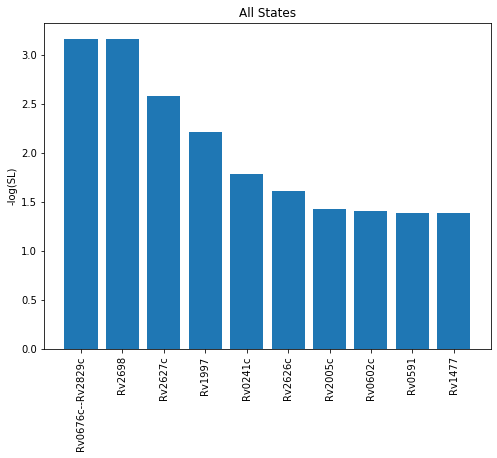

In [4]:
util_classifier.plotStateFstat(None, trinary_long.df_X, trinary_long.ser_y)

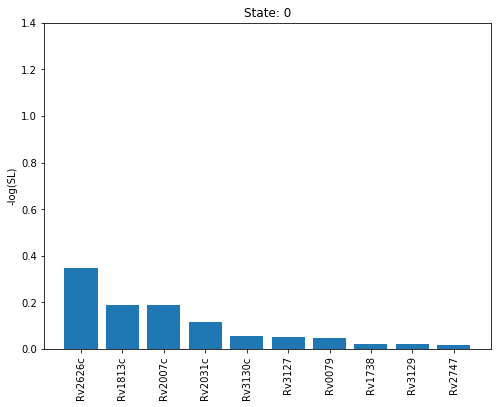

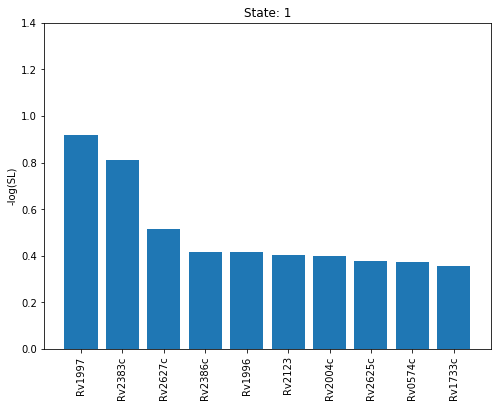

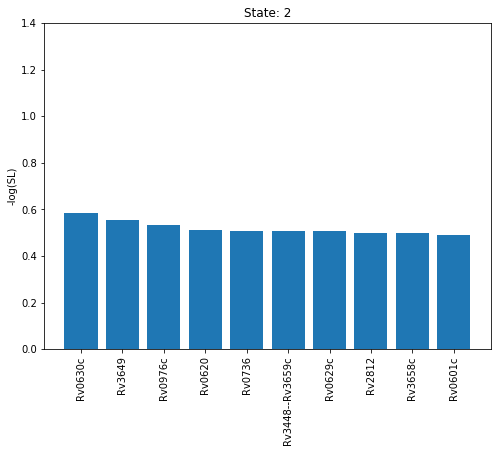

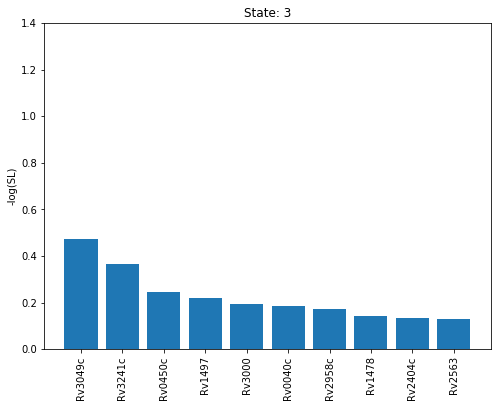

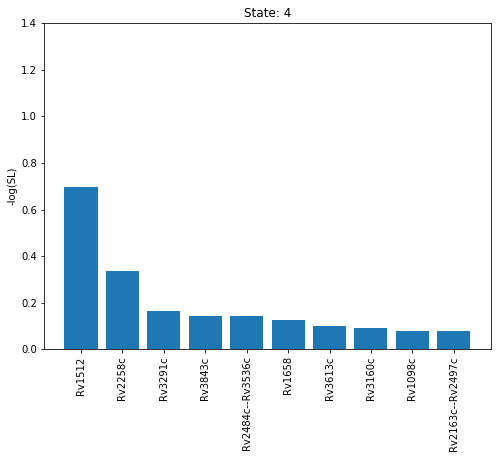

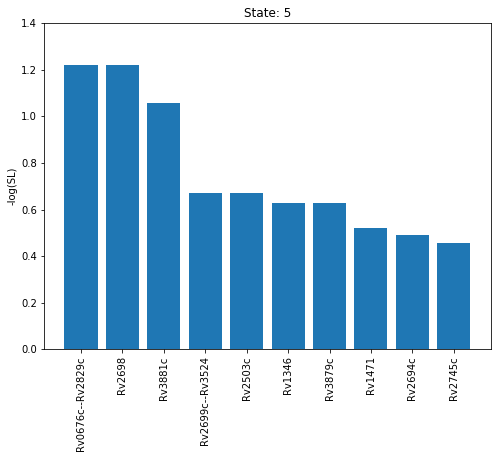

In [5]:
for state in trinary_long.ser_y.unique():
    util_classifier.plotStateFstat(state, trinary_long.df_X, trinary_long.ser_y)

## Comparison of Genes F-Statistics Across State

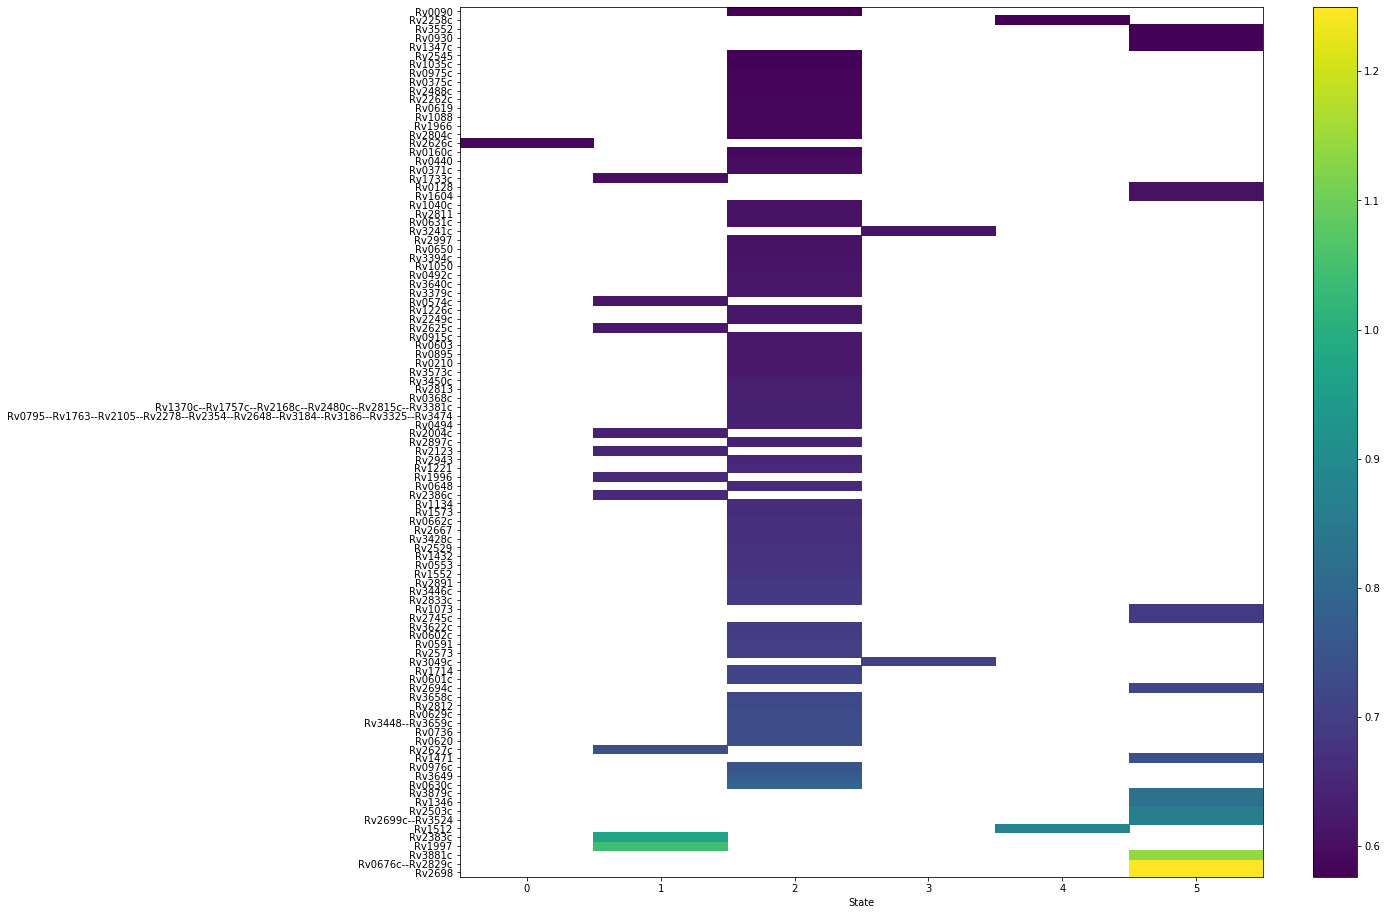

In [21]:
trinary_long.plotFeatureSignificanceByState(max_sl=0.5, max_rank=100, figsize=(18, 16))


In [15]:
trinary_long.df_fstat.loc[trinary_long.df_fstat.index[80:100],:]

,0,1,2,3,4,5
Rv0371c,0.002961,0.050745,0.600460,0.077851,0.000004,0.057195
Rv0440,0.002613,0.022850,0.599091,0.017519,0.009013,0.012952
Rv0160c,0.000082,0.145733,0.590945,0.080630,0.023569,0.034288
Rv2626c,0.590571,0.012313,0.017651,0.013565,0.007007,0.010050
Rv2804c,0.000611,0.118070,0.589101,0.120140,0.008384,0.012855
Rv1966,0.001179,0.101086,0.587631,0.073884,0.024818,0.076750
Rv1088,0.001179,0.101086,0.587631,0.052284,0.012000,0.076750
Rv0619,0.001179,0.055361,0.587631,0.073884,0.003862,0.076750
Rv2262c,0.001179,0.101086,0.587631,0.052284,0.012000,0.076750
Rv2488c,0.003811,0.063456,0.582923,0.070509,0.000188,0.051843


In [10]:
df.loc["Rv0620", :]

0    0.000881
1    0.071400
2    0.736891
3    0.098856
4    0.002883
5    0.072546
Name: Rv0620, dtype: float64